# CCD dataset analysis

This notebook aims to assess our model's performances on the dataset CCD. It is applied to the cingulate region.

In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.svm import LinearSVC

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"

In [3]:
model_dir = '/neurospin/dico/lguillon/distmap/CCD/runs/left/seed_10/checkpoint.pt'
model = VAE((1, 32, 136, 112), 75, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

### Loading of HCP test set

In [4]:
subject_dir = "/neurospin/dico/lguillon/distmap/CCD/data/"
data_dir = "/neurospin/dico/lguillon/distmap/CCD/data/"
test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))
distmaps = np.load(os.path.join(data_dir, "Ltest_distmap.npy"),
                   mmap_mode='r')
filenames = np.load(os.path.join(data_dir, "Ltest_sub_id.npy"))
print(distmaps.shape, filenames.shape)

subset = SkeletonDataset(dataframe=distmaps,
                         filenames=filenames,
                         data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

(193, 30, 130, 108, 1) (193,)


### Loading of CCD data

In [5]:
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/CCD"
data_path = "crops/1mm/no_mask"

In [6]:
controls = np.load(os.path.join(data_dir, "controls", data_path, "Lskel_all.npy"),
                   mmap_mode='r')
filenames_controls = np.load(os.path.join(data_dir, "controls", data_path, "sub_id_skel_all.npy"))

subset_controls = SkeletonDataset(dataframe=controls,
                                 filenames=filenames_controls,
                                 data_transforms=False)
loader_controls = torch.utils.data.DataLoader(
               subset_controls,
               batch_size=1,
               num_workers=1,
               shuffle=False)

ccd_subjects = np.load(os.path.join(data_dir, "ccd_subjects", data_path, "Lskel_all.npy"),
                   mmap_mode='r')
filenames_ccd_subjects = np.load(os.path.join(data_dir, "ccd_subjects", data_path, "Lsub_id_skel_all.npy"))

subset_ccd_subjects = SkeletonDataset(dataframe=ccd_subjects,
                             filenames=filenames_ccd_subjects,
                             data_transforms=False)
loader_ccd_subjects = torch.utils.data.DataLoader(
                       subset_ccd_subjects,
                       batch_size=1,
                       num_workers=1,
                       shuffle=False)

In [7]:
dico_set_loaders = {'hcp_test': testloader, 'controls': loader_controls, 'ccd_subjects': loader_ccd_subjects}

root_dir = '/neurospin/dico/lguillon/distmap/CCD/results/'

criterion = nn.MSELoss(reduction='sum')
tester_deletion = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_deletion = tester_deletion.test()
encoded_deletion = {loader_name:[results_deletion[loader_name][k][1] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_deletion = {loader_name:[int(results_deletion[loader_name][k][0].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_deletion = {loader_name:[int(results_deletion[loader_name][k][2].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_deletion = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
var_deletion = {loader_name:[results_deletion[loader_name][k][4] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

hcp_test
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 6.7234039e-05 9.5129013e-05 ... 9.9960482e-01 9.9966359e-01
 9.9988246e-01]
(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 6.0319901e-05 6.3180923e-05 ... 9.9925232e-01 9.9963689e-01
 9.9965286e-01]
(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 4.6014786e-05 4.8160553e-05 ... 9.9870181e-01 9.9903870e-01
 9.9954569e-01]
(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
[0.0000000e+00 4.8160553e-05 6.3657761e-05 ... 9.9932945e-01 9.9962080e-01
 9.9998927e-01]
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
[0.000000e+00 6.747246e-05 7.414818e-05 ... 9.992844e-01 9.998398e-01
 9.998561e-01]
(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
[0.0000000e+00 3.4093857e-05 3.5047531e-05 ...

(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 1.2207031e-04 1.2540817e-04 ... 9.9961019e-01 9.9982917e-01
 9.9986112e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 1.1610985e-04 1.3065338e-04 ... 9.9962616e-01 9.9963689e-01
 9.9973822e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
[0.0000000e+00 1.8811226e-04 1.9574165e-04 ... 9.9925768e-01 9.9935913e-01
 9.9939656e-01]
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
[0.00000000e+00 1.15156174e-04 1.44243240e-04 ... 9.98953223e-01
 9.99636889e-01 9.99690294e-01]
(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 1.6689301e-06 2.1457672e-06 ... 9.9927902e-01 9.9943006e-01
 9.9964750e-01]
(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 2.1266937e-04 2.3198128e-04 ... 9.9962616e-01 9.99887

(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 1.9383430e-04 2.2077560e-04 ... 9.9961555e-01 9.9962616e-01
 9.9967957e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 1.0967255e-05 1.2636185e-05 ... 9.9914551e-01 9.9989712e-01
 9.9997330e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 3.2663345e-05 3.8385391e-05 ... 9.9917221e-01 9.9928439e-01
 9.9969029e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 3.0755997e-05 3.9815903e-05 ... 9.9980772e-01 9.9986649e-01
 9.9992526e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 1.9073486e-05 2.0742416e-05 ... 9.9949801e-01 9.9956203e-01
 9.9983978e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 6.9141388e-06 9.0599060e-06 ... 9.9902797e-01 9.9917758e-01

(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 8.7022781e-05 9.0599060e-05 ... 9.9901199e-01 9.9902797e-01
 9.9932706e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 3.4093857e-05 4.1246414e-05 ... 9.9962616e-01 9.9991453e-01
 9.9995720e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 2.1457672e-06 2.8610229e-06 ... 9.9902797e-01 9.9932528e-01
 9.9943388e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 3.2901764e-05 4.1246414e-05 ... 9.9852049e-01 9.9876094e-01
 9.9904406e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 2.2172928e-05 2.3126602e-05 ... 9.9916685e-01 9.9920964e-01
 9.9963152e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 2.2411346e-05 3.5047531e-05 ... 9.9970090e-01 9.9976504e-01
 9.9976933e-01]
i

(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
[0.0000000e+00 2.3841858e-06 3.3378601e-06 ... 9.9946594e-01 9.9988556e-01
 9.9994969e-01]
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 3.5762787e-06 5.0067902e-06 ... 9.9979401e-01 9.9983132e-01
 9.9994504e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 9.7751617e-06 1.9788742e-05 ... 9.9934757e-01 9.9936485e-01
 9.9986267e-01]
(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
[0.00000000e+00 1.04904175e-05 1.19209290e-05 ... 9.99343872e-01
 9.99574542e-01 9.99877930e-01]
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 1.9073486e-06 2.3841858e-06 ... 9.9861145e-01 9.9971771e-01
 9.9999237e-01]
(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
[0.0000000e+00 7.1525574e-06 7.8678131e-06 ... 9.9938

In [138]:
df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded_deletion['hcp_test'] +encoded_deletion['controls']+ encoded_deletion['ccd_subjects']
df_encoded['loss'] = losses_deletion['hcp_test'] + losses_deletion['controls'] + losses_deletion['ccd_subjects']
df_encoded['recon'] = recon_deletion['hcp_test'] + recon_deletion['controls'] +recon_deletion['ccd_subjects']
df_encoded['input'] = input_deletion['hcp_test'] + input_deletion['controls'] + input_deletion['ccd_subjects']
df_encoded['sub'] = list(filenames) + list(filenames_controls) + list(filenames_ccd_subjects) 
df_encoded['group'] = ['hcp_test' for k in range(len(list(filenames)))] + ['controls' for k in range(len(list(filenames_controls)))] + ['ccd_subjects' for k in range(len(list(filenames_ccd_subjects)))] 

In [139]:
deletion_hcp = pd.DataFrame()
deletion_hcp['latent'] = encoded_deletion['hcp_test']
deletion_hcp['loss'] = losses_deletion['hcp_test']  
deletion_hcp['recon'] = recon_deletion['hcp_test']   
deletion_hcp['input'] = input_deletion['hcp_test'] 
deletion_hcp['sub'] = list(filenames) 

In [140]:
deletion_controls = pd.DataFrame()
deletion_controls['latent'] = encoded_deletion['controls']
deletion_controls['loss'] = losses_deletion['controls']  
deletion_controls['recon'] = recon_deletion['controls']   
deletion_controls['input'] = input_deletion['controls'] 
deletion_controls['sub'] = list(filenames_controls) 

In [141]:
deletion_ccd_subjects = pd.DataFrame()
deletion_ccd_subjects['latent'] = encoded_deletion['ccd_subjects']
deletion_ccd_subjects['loss'] = losses_deletion['ccd_subjects']  
deletion_ccd_subjects['recon'] = recon_deletion['ccd_subjects']   
deletion_ccd_subjects['input'] = input_deletion['ccd_subjects'] 
deletion_ccd_subjects['sub'] = list(filenames_ccd_subjects) 

## L_{D} metric computation

In [9]:
data_dir = '/neurospin/dico/lguillon/distmap/CCD/data/'
filenames_all = np.load(os.path.join(data_dir,
                                "Ltrain_sub_id.npy"))
distmaps = np.load(os.path.join(data_dir,
                                "Ltrain_distmap.npy"),
                       mmap_mode='r')

subset_sc = SkeletonDataset(dataframe=distmaps, filenames=filenames_all, data_transforms=False)
sc_loader = torch.utils.data.DataLoader(
                          subset_sc,
                          batch_size=8,
                          num_workers=8,
                          shuffle=False)

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders={'hcp_train': sc_loader},
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp_all = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
losses_hcp_all = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
recon_hcp_all = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
input_hcp_all = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
var_hcp_all = {loader_name:[results_hcp[loader_name][k][4] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}

df_encoded_hcp_all = pd.DataFrame()
df_encoded_hcp_all['latent'] = encoded_hcp_all['hcp_train']
df_encoded_hcp_all['loss'] = losses_hcp_all['hcp_train']
df_encoded_hcp_all['recon'] = recon_hcp_all['hcp_train']
df_encoded_hcp_all['input'] = input_hcp_all['hcp_train']
df_encoded_hcp_all['var'] = var_hcp_all['hcp_train']
df_encoded_hcp_all['Group'] = ['hcp_train' for k in range(len(filenames_all))] 
df_encoded_hcp_all['sub'] = list(filenames_all)

hcp_train
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108,

(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30

(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108, 1)
[0.0000000e+00 6.4373016e-06 6.6757202e-06 ... 9.9981844e-01 9.9994659e-01
 9.9999464e-01]
(30, 130, 108)
[0.0000000e+00 3.7670135e-05 3.8146973e-05 ... 9.9991453e-01 9.9994123e-01
 9.9996793e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)

(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 

(30, 130, 108)
[0.0000000e+00 1.0728836e-05 1.0967255e-05 ... 9.9997079e-01 9.9999464e-01
 9.9999654e-01]
[0.0000000e+00 2.4795532e-05 3.2663345e-05 ... 9.9975562e-01 9.9977577e-01
 9.9990392e-01]
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 10

(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 

ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 1

(30, 130, 108)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108, 1)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 130, 108, 1)
(30, 130, 108)
ici
(1, 30, 1

In [14]:
def dev(latent_sub, var_sub):
    """
    """
    n = len(latent_sub)
    n_ctrl = len(encoded_hcp_all)
    mean_ctrl = [np.mean([encoded_hcp_all['hcp_train'][k][i] for k in range(n_ctrl)]) for i in range(75)]
    var_ctrl =  [np.var([encoded_hcp_all['hcp_train'][k][i] for k in range(n_ctrl)]) for i in range(75)]
    deviations = []
    
    for k in range(n):
        deviations.append(abs(latent_sub[k] - mean_ctrl[k])/np.sqrt(var_ctrl[k]+var_sub[k]))
    return(np.mean(deviations))

In [15]:
dev_test = [dev(encoded_deletion['hcp_test'][k], var_deletion['hcp_test'][k]) for k in range(len(encoded_deletion['hcp_test']))]
dev_controls = [dev(encoded_deletion['controls'][k], var_deletion['controls'][k]) for k in range(len(encoded_deletion['controls']))]
dev_ccd = [dev(encoded_deletion['ccd_subjects'][k], var_deletion['ccd_subjects'][k]) for k in range(len(encoded_deletion['ccd_subjects']))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f14310b0da0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f14310c6390>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f14310b0b38>,
 'medians': [<matplotlib.lines.Line2D at 0x7f14310c6940>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f14310c6c18>,
 'means': []}

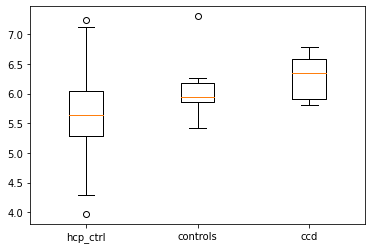

In [16]:
plt.boxplot((dev_test, dev_controls, dev_ccd),
            labels=('hcp_ctrl','controls', 'ccd'))

In [17]:
F,p = mannwhitneyu(dev_test, dev_controls)
print(p)
F,p = mannwhitneyu(dev_test, dev_ccd)
print(p)
F,p = mannwhitneyu(dev_controls, dev_ccd)
print(p)

0.03182092723774356
0.002128458415751948
0.26145161725633537


### Latent space analysis - all data

In [142]:
X_all = np.array(list(deletion_hcp['latent']) + list(deletion_controls['latent']) + list(deletion_ccd_subjects['latent']))
labels = np.array(['hcp_test' for k in range(193)] + ['controls' for k in range(7)] + ['ccd_subjects' for k in range(7)])

In [212]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2, perplexity=5).fit_transform(X_all)

In [262]:
reducer = umap.UMAP(random_state=5)
embedding = reducer.fit_transform(X_all)

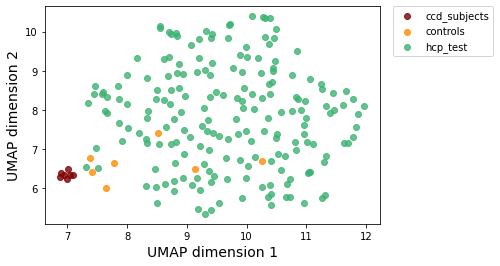

In [263]:
arr = embedding
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 'ccd_subjects':'maroon'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=0.8)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

# for i, txt in enumerate(list(deletion_ccd_subjects['sub'])):
#         ax.annotate(txt, (embedding[200:][i][0], embedding[200:][i][1]))

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Latent space analysis - CCD data

In [149]:
X_ccd = np.array(list(deletion_controls['latent']) + list(deletion_ccd_subjects['latent']))
labels_ccd = np.array(['controls' for k in range(7)] + ['ccd_subjects' for k in range(7)])

In [150]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_ccd)

/casa/home/.local/lib/python3.6/site-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


In [151]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(X_ccd)

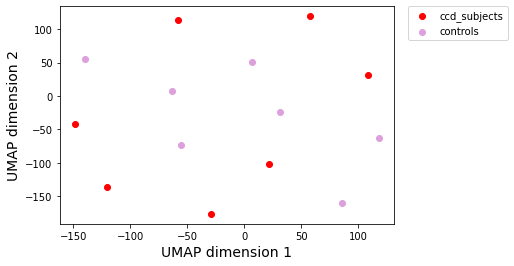

In [152]:
arr = X_embedded
color_dict = {'hcp_test':'mediumseagreen','controls': 'plum', 'ccd_subjects':'red'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_ccd):
    ix = np.where(labels_ccd == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

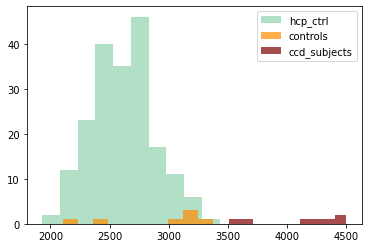

In [264]:
plt.subplot()
plt.hist(deletion_hcp.recon, color='mediumseagreen', alpha=0.4, label='hcp_ctrl',bins=10)
plt.hist(deletion_controls.recon, color='darkorange', alpha=0.7, label='controls', bins=10)
plt.hist(deletion_ccd_subjects.recon, color='maroon', alpha=0.7, label='ccd_subjects', bins=10)
plt.xlabel('')
plt.legend()

In [274]:
F,p = mannwhitneyu(deletion_hcp.recon, deletion_controls.recon)
print(p)
F,p = mannwhitneyu(deletion_controls.recon, deletion_ccd_subjects.recon)
print(p)
F,p = mannwhitneyu(deletion_hcp.recon, deletion_ccd_subjects.recon)
print(p)

0.016562078262803294
0.0010825146665191896
3.6087889891334215e-06


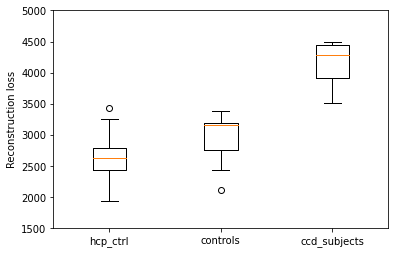

In [275]:
plt.boxplot((deletion_hcp.recon, deletion_controls.recon, deletion_ccd_subjects.recon),
            labels=('hcp_ctrl','controls','ccd_subjects'))
plt.ylabel('Reconstruction loss')
plt.ylim(1500,5000)
plt.rcParams['axes.grid'] = False

In [110]:
deletion_ccd_subjects.head()

,latent,loss,recon,input,sub
0,"[-0.29707557, 0.16868019, 1.5462962, -0.606723...",5112,4843,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,110410
1,"[0.31594038, 0.6003983, 2.1066918, 0.25074753,...",4987,4741,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,080037
2,"[-0.4627594, -0.7647403, 0.8369406, -0.7593972...",4258,3983,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,090293
3,"[-1.3606733, -0.5115801, 1.3422695, -1.316254,...",5296,5035,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,080261
4,"[1.5204542, -0.29236552, 1.1120338, 0.19633362...",4687,4367,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,090301


### Average patterns

In [267]:
enc_hcp = np.array([np.mean([deletion_hcp.latent[k][i] for k in range(len(deletion_hcp))]) for i in range(75)])

In [268]:
tgt_dir = '/tmp/'

z = torch.from_numpy(np.array(enc_hcp)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.4] = 1
out[out<=0.4] = 0

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}hcp_bucket.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}hcp_mesh_2.mesh")

In [269]:
enc_controls = np.array([np.mean([deletion_controls.latent[k][i] for k in range(len(deletion_controls))]) for i in range(75)])

In [270]:
tgt_dir = '/tmp/'

z = torch.from_numpy(np.array(enc_controls)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.4] = 1
out[out<=0.4] = 0

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}ctrl_bucket.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}ctrl_mesh_2.mesh")

In [271]:
enc_ccd = np.array([np.mean([deletion_ccd_subjects.latent[k][i] for k in range(len(deletion_ccd_subjects))]) for i in range(75)])

In [272]:
tgt_dir = '/tmp/'

z = torch.from_numpy(np.array(enc_ccd)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.4] = 1
out[out<=0.4] = 0

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}ccd_bucket.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}ccd_mesh_2.mesh")

### Reconstruction

In [36]:
deletion_ccd_subjects

,latent,loss,recon,input,sub
0,"[-0.40134007, 0.45182195, 2.2958794, -2.168514...",4775,4499,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,110410
1,"[0.8640986, -1.7515069, 0.5634486, -0.13522437...",4642,4385,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,080037
2,"[1.6114353, -0.89633137, 2.002815, -0.85040617...",3695,3411,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,090293
3,"[-1.033106, -1.5195292, 1.2792279, -0.27112734...",4778,4508,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,080261
4,"[-0.121529356, 0.20856276, 1.2554734, -0.64240...",4051,3765,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,090301
5,"[0.39792606, -0.77501494, 0.72815305, -1.83848...",4680,4404,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,070055
6,"[-0.252307, 0.49445784, 0.96110624, -1.372291,...",4892,4626,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,070065


In [143]:
tgt_dir = "/neurospin/dico/lguillon/distmap/CCD/results/"

for k in range(len(deletion_ccd_subjects)):
    enc = deletion_ccd_subjects.latent[k]
    sub = deletion_ccd_subjects['sub'][k]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.5] = 1
    out[out<=0.5] = 0
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}{sub}_reconstruction.mesh")

In [147]:
input_data = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

In [155]:
len(input_data['ccd_subjects'])

7

In [161]:
tgt_dir = "/neurospin/dico/lguillon/distmap/CCD/results/"

for k in range(len(deletion_ccd_subjects)):
    enc = deletion_ccd_subjects.latent[k]
    input_ccd = np.squeeze(input_data['ccd_subjects'][k])
    sub = deletion_ccd_subjects['sub'][k]
    
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    
    error = input_ccd - out
    error2 = out - input_ccd

    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error)), 
            f"{tgt_dir}{sub}_error_missing.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error2)), 
               f"{tgt_dir}{sub}_error_adding.mesh")